### ResNet-Residual
- ResNet-50 (standard) + Conv-BN blocks (repeated)

Best Model
- Epoch 10: loss: 0.7501 - accuracy: 0.6792 - val_loss: 1.2903 - val_accuracy: 0.4803


In [0]:
from google.colab import drive
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [0]:
!cp 'drive/My Drive/cs231n-project/datasets/emotiw/train_frames.tar.gz' .

In [0]:
!tar -xzf train_frames.tar.gz

In [0]:
!cp 'drive/My Drive/cs231n-project/datasets/emotiw/val_frames.tar.gz' .
!tar -xzf val_frames.tar.gz

In [0]:
!ls 'drive/My Drive/cs231n-project/datasets/emotiw/'

 AutomaticGroupLevelAffectandCohesion.pdf   Train.zip
'Copy of Train.zip'			    unzip.ipynb
'Copy of Val.zip'			    val
 models					    val_frames.tar.gz
 train					    Val_labels.txt
 train_frames.tar.gz			    Val.zip
 Train_labels.txt			    VGAF_readme.txt


In [0]:
!nvidia-smi

Sat May 23 07:17:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import numpy as np
import random
import cv2
from os import listdir
from os.path import isfile, join

class DataGenerator(tf.keras.utils.Sequence):
    """
    Generates data based on a directory of frames
    """
    def __init__(self, dir, batch_size=32, frames_to_use=-1, shuffle=True):
        self.frames_to_use = frames_to_use
        self.batch_size = batch_size
        self.dir = dir
        self.shuffle = shuffle
        self.classes = self.find_classes()
        self.video_names, self.video_map, self.video_to_class, self.num_samples, self.min_frames = self.find_samples()
        self.on_epoch_end()
        print(f"Found {self.num_samples} frames belonging to {len(self.video_names)} videos belonging to {len(self.classes)} classes.")
        print(f"Min frames determined to be {self.min_frames}")

    def find_classes(self):
        category_folders = [f for f in listdir(self.dir) if not isfile(join(self.dir, f))]
        return sorted(list(set(category_folders)))

    def find_samples(self):
        """
        Returns the following video frame structure:

        {
            "vid1": [
                "frame1.jpg",
                "frame2.jpg",
                ...
            ]
        }

        """
        num_samples = 0
        min_frames = -1
        video_map = {}
        vid_to_cat = {}
        category_folders = [f for f in listdir(self.dir) if not isfile(join(self.dir, f))]
        for category_folder in category_folders:
            cat_path = join(self.dir, category_folder)
            frames = [f for f in listdir(cat_path) if isfile(join(cat_path, f))]
            for frame in frames:
                # frame = frame_101_7.mp4_8.jpg
                frame_arr = frame.split(".mp4_")
                vid_name = frame_arr[0]
                if vid_name not in video_map:
                    video_map[vid_name] = []
                    vid_to_cat[vid_name] = category_folder
                video_map[vid_name].append(frame)
            
            for k in video_map.keys():
                # make sure the frames for each video are in sorted order
                video_map[vid_name] = sorted(video_map[vid_name])
                if min_frames == -1 or len(video_map[vid_name]) < min_frames:
                    min_frames = len(video_map[vid_name])

        return list(video_map.keys()), video_map, vid_to_cat, len(vid_to_cat), min_frames

    def __len__(self):
        """
        Denotes the number of batches per epoch
        """
        return int(np.floor(self.num_samples / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data
        """
        video_names = self.video_names[index*self.batch_size:(index+1)*self.batch_size]

        # print(f"Working on batch {index} with {len(video_names)} videos")

        num_frames = self.min_frames if self.frames_to_use == -1 else self.frames_to_use
        X = np.zeros((len(video_names), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
        y = []
        i = 0
        for vid in video_names:
            # print(vid)
            for frame in self.video_map[vid]:
                # print("   " + frame)
                frame_path = join(join(self.dir, self.video_to_class[vid]), frame)
                img = cv2.imread(frame_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # Assume resized already
                # img = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_CUBIC)
                # print(img[0])
                X[i, :, :, :] = img
                break

            y.append(int(self.video_to_class[vid]) - 1)
            # print(f"{vid} - {int(self.video_to_class[vid]) - 1}")
            i += 1
        y = np.array(y)
        return X, tf.keras.utils.to_categorical(y, num_classes=len(self.classes))

    def on_epoch_end(self):
        # print("on_epoch_end")
        if self.shuffle == True:
            np.random.shuffle(self.video_names)




In [0]:
#
# CONFIGURATION
#
# Define any constants for the model here
#

IMG_WIDTH = 480
IMG_HEIGHT = 320
FRAMES = 1
BATCH_SIZE = 8
BASE_NAME = "resnet50"
MODEL_NAME = "resnet-residual"

In [0]:
train_generator = DataGenerator("train_frames", frames_to_use=FRAMES, batch_size=BATCH_SIZE)
validation_generator = DataGenerator("val_frames", frames_to_use=FRAMES, batch_size=BATCH_SIZE)

X, y = train_generator.__getitem__(0)


Found 2661 frames belonging to 2661 videos belonging to 3 classes.
Min frames determined to be 13
Found 766 frames belonging to 766 videos belonging to 3 classes.
Min frames determined to be 13


(8, 320, 480, 3)


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


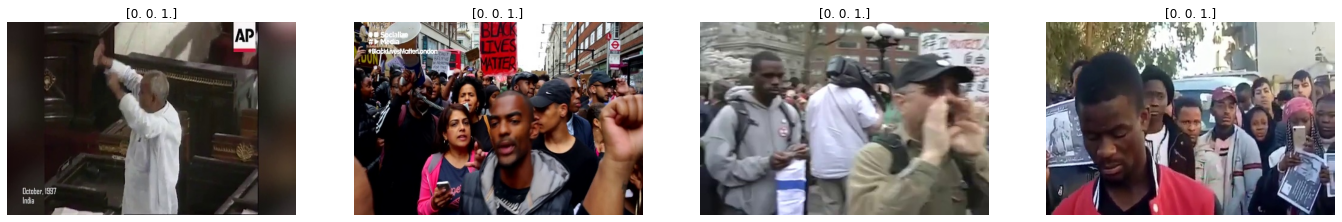

In [0]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(30,30))
    for n in range(4):
          ax = plt.subplot(5,5,n+1)
          plt.imshow(image_batch[n])
          plt.title(label_batch[n])
          plt.axis('off')
image_batch, label_batch = train_generator.__getitem__(1)
print(image_batch.shape)
show_batch(image_batch, label_batch)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


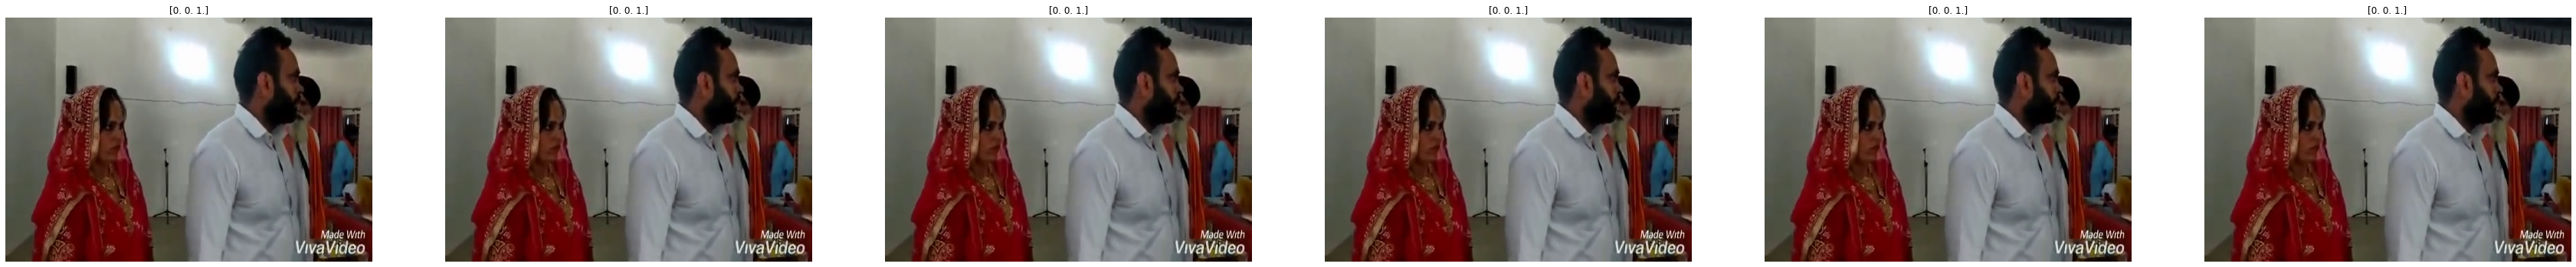

In [0]:
def show_frames_batch(image_batch, label_batch):
    plt.figure(figsize=(60,60))
    for n in range(6):
        ax = plt.subplot(1,6,n+1)
        plt.imshow(image_batch[0])
        plt.title(label_batch[0])
        plt.axis('off')
image_batch, label_batch = train_generator.__getitem__(0)
show_frames_batch(image_batch, label_batch)

In [0]:
from pathlib import Path
import tensorflow.keras.layers as layers


IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

Path(f"drive/My Drive/checkpoints/{MODEL_NAME}").mkdir(parents=True, exist_ok=True)
checkpoint_path = "drive/My Drive/checkpoints/" + MODEL_NAME + "/cp-{epoch:04d}.ckpt"

# Create a callback that saves the model's weights every 1 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=True,
    period=1)

def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    bn_axis = 3
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x


def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        strides: Strides for the first conv layer in the block.
    # Returns
        Output tensor for the block.
    Note that from stage 3,
    the first conv layer at main path is with strides=(2, 2)
    And the shortcut should have strides=(2, 2) as well
    """
    filters1, filters2, filters3 = filters
    bn_axis = 3
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(
        axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x


def create_resnetwithresidual_model(inputs):
    base_model = get_base_model(BASE_NAME)
    base_model.trainable = False
    # for layer in base_model.layers[:NUM_TOP_LAYERS_TO_RETRAIN]:
    #     layer.trainable = False
    # for layer in base_model.layers[NUM_TOP_LAYERS_TO_RETRAIN:]:
    #     layer.trainable = True

    x1 = base_model(inputs)
    x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)
    x1 = tf.keras.layers.Dense(512)(x1)



    bn_axis = 3
    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(inputs)
    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x2 = tf.keras.layers.GlobalAveragePooling2D()(x)
    x2 = tf.keras.layers.Dense(512)(x2)

    x3 = tf.keras.layers.Add()([x1, x2])
    print(x.shape)
    x4 = tf.keras.layers.Dense(512)(x3)
    x4 = tf.keras.layers.Dense(3, activation='softmax')(x4)
    model = tf.keras.Model(inputs=inputs, outputs=x4)
    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def get_base_model(model_name="resnet50"):
    if model_name == 'inception_v3':
        return tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'xception':
        return tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg16':
        return tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'vgg19':
        return tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    elif model_name == 'resnet50':
        return tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
    else:
        raise ValueError(f"Cannot find base model {model_name}")

inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
model = create_resnetwithresidual_model(inputs)
model.summary()


# model(tf.random.uniform((320, 480, 3)))

(None, 40, 60, 512)
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           [(None, 320, 480, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 326, 486, 3)  0           input_39[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 160, 240, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 160, 240, 64) 256         conv1[0][0]                      
_______________________________________________________________________

In [0]:
initial_epochs = 30

# Try evaluating the model for a few rounds
# history = model.fit(train_generator, epochs=1)
loss0, accuracy0 = model.evaluate(validation_generator, steps = 3)

3/3 [==============================] - 1s 202ms/step - loss: 2149.6047 - accuracy: 0.2917


In [0]:
validation_generator.batch_size

8

In [0]:
import pickle
history = model.fit(
          train_generator,
          epochs=initial_epochs,
          callbacks=[cp_callback],
          validation_data=validation_generator
)

with open(f"drive/My Drive/checkpoints/{MODEL_NAME}/history-v2.pkl", 'wb') as handle:
    pickle.dump(history.history, handle)

Epoch 1/30
332/332 [==============================] - ETA: 0s - loss: 1.6749 - accuracy: 0.4725
Epoch 00001: saving model to drive/My Drive/checkpoints/resnet-residual/cp-0001.ckpt
332/332 [==============================] - 190s 574ms/step - loss: 1.6749 - accuracy: 0.4725 - val_loss: 1.8089 - val_accuracy: 0.3829
Epoch 2/30
332/332 [==============================] - ETA: 0s - loss: 1.0368 - accuracy: 0.5595
Epoch 00002: saving model to drive/My Drive/checkpoints/resnet-residual/cp-0002.ckpt
332/332 [==============================] - 191s 576ms/step - loss: 1.0368 - accuracy: 0.5595 - val_loss: 1.5027 - val_accuracy: 0.4434
Epoch 3/30
332/332 [==============================] - ETA: 0s - loss: 0.8670 - accuracy: 0.6205
Epoch 00003: saving model to drive/My Drive/checkpoints/resnet-residual/cp-0003.ckpt
332/332 [==============================] - 191s 575ms/step - loss: 0.8670 - accuracy: 0.6205 - val_loss: 1.3391 - val_accuracy: 0.4566
Epoch 4/30
332/332 [==============================] 

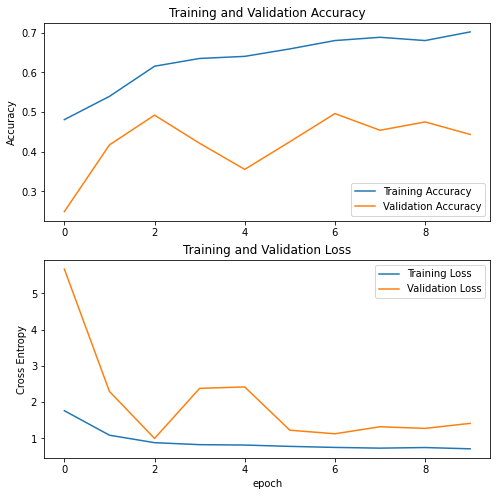

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# model.save(f"drive/My Drive/checkpoints/{MODEL_NAME}/m1.h5") # contains first 10 epochs
model.save(f"drive/My Drive/checkpoints/{MODEL_NAME}/m2.h5") # contains first 30 epochs
